## Strategy QA: Multiple Choice

Dataset Source: https://huggingface.co/datasets/tasksource/bigbench/viewer/strategyqa/train

#### Import Necessary Libraries

In [1]:
import os, sys, random, ast
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict, load_dataset

import torch

from dataclasses import dataclass

import transformers
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from transformers import Trainer, TrainingArguments, set_seed
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy

from typing import Optional, Union

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.12
         NumPy: 1.25.1
        Pandas: 2.0.3
         Torch: 2.0.1
      Datasets: 2.13.1
  Transformers: 4.26.1


#### Load Dataset & Convert To Pandas DataFrame

In [2]:
data = load_dataset("tasksource/bigbench", "strategyqa")

data = data.rename_column("inputs", "context")

data.set_format(type="pandas")

df = data['train'][:]

df = df.dropna(how='all')

df = df.drop_duplicates(subset='context')

df['labels'] = df['targets'].apply(lambda x: x[0])

mc_target_values = ['Yes', 'No']

df['0'] = df['multiple_choice_targets'].apply(lambda x: mc_target_values[0])
df['1'] = df['multiple_choice_targets'].apply(lambda x: mc_target_values[1])


df['labels'] = df['multiple_choice_scores'].apply(lambda x: 1 if x[0] == 0 else 0)

df = df.drop(columns=["multiple_choice_targets", "idx", "multiple_choice_scores", "targets"])

df

Found cached dataset bigbench (/Users/briandunn/.cache/huggingface/datasets/tasksource___bigbench/strategyqa/1.0.0/c5da5ac497141c7435da10444495b8577405d4ed01e524265b144a7063718c0c)


  0%|          | 0/2 [00:00<?, ?it/s]

,context,labels,0,1
0,Q: Was the Louisiana Purchase made with bitcoi...,1,Yes,No
1,Q: Is someone more likely to survive having br...,1,Yes,No
2,Q: Are you likely to hear Rammstein playing in...,1,Yes,No
3,Q: Could the moon fit inside the Black Sea?\nA:,1,Yes,No
4,Q: Can Arnold Schwarzenegger deadlift an adult...,1,Yes,No
...,...,...,...,...
1827,Q: Were there greater landslides than 1980 Uni...,0,Yes,No
1828,Q: Would Eye surgery on a fly be in vain?\nA:,0,Yes,No
1829,Q: Was John Lennon known to be a good friend t...,1,Yes,No
1830,Q: Did Martin Luther believe in Satan?\nA:,0,Yes,No


#### Visual: Word Length of Training Dataset Inputs

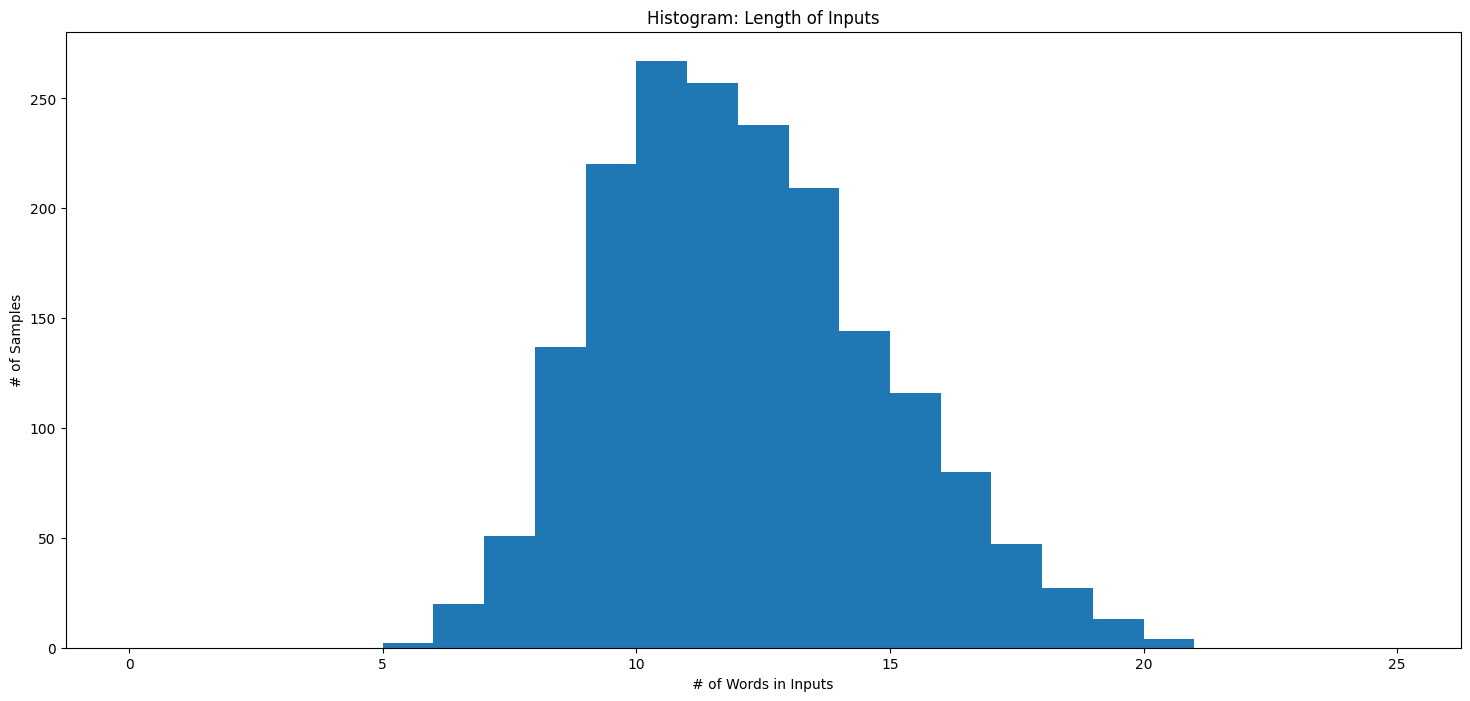

The maximum length of inputs is 20 words.


In [3]:
df['input_length'] = df['context'].str.split().str.len()

n_bin= 25
df.hist('input_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Inputs')
plt.xlabel('# of Words in Inputs')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of inputs is {max(df['input_length'])} words.")

df = df.drop(columns=['input_length'])

#### Convert from DataFrame to Dataset & Split into Training/Testing/Evaluation Datasets

In [5]:
dataset = Dataset.from_pandas(df)

train_testeval = dataset.train_test_split(test_size=0.20)
test_eval = train_testeval['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testeval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

print(ds['train'].features)

Training Dataset Shape: (1465, 4)
Testing Dataset Shape: (183, 4)
Evaluation Dataset Shape: (184, 4)
{'context': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), '0': Value(dtype='string', id=None), '1': Value(dtype='string', id=None)}


#### Display Example

In [6]:
ds['train'][12]

{'context': 'Q: Was  Godfrey of Bouillon an Islamaphobe?\nA:',
 'labels': 0,
 '0': 'Yes',
 '1': 'No'}

#### Create Function to Display an Example Sample

In [7]:
def show_one_example(sample):
    print(f"Context: {sample['context']}")
    print(f"\nGround Truth: {mc_target_values[sample['labels']]}")

#### Display an Example Sample

In [8]:
show_one_example(ds['train'][12])

Context: Q: Was  Godfrey of Bouillon an Islamaphobe?
A:

Ground Truth: Yes


#### Basic Values/Constants

In [9]:
MODEL_CKPT = "bert-base-uncased"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Multiple_Choice-Strategy_QA"

STRATEGY = "epoch"
LEARNING_RATE = 5e-5

BATCH_SIZE = 16
NUM_OF_EPOCHS = 10

WEIGHT_DECAY = 0.01
REPORTS_TO = "tensorboard"

set_seed = 42

#### Instantiate Tokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                          use_fast=True)

#### Create Preprocessing Function

In [11]:
ending_names = ["0", "1"]

def preprocess_function(samples):
    first_sentences = [[context] * len(ending_names) for context in samples['context']]
    
    question_headers = samples['context']
    second_sentences = [[f"{header} {samples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)]
    
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])
    
    tokenized_samples = tokenizer(first_sentences, second_sentences, truncation=True)
    return {k: [v[i:i + len(ending_names)] for i in range(0, len(v), len(ending_names))] for k, v in tokenized_samples.items()}

#### Apply Preprocessing Function to Dataset

In [12]:
encoded_ds = ds.map(preprocess_function, 
                    batched=True)

Map:   0%|          | 0/1465 [00:00<?, ? examples/s]

Map:   0%|          | 0/183 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

In [13]:
encoded_ds['train'].features

{'context': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None),
 '0': Value(dtype='string', id=None),
 '1': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None)}

#### Instantiate Model

In [14]:
model = AutoModelForMultipleChoice.from_pretrained(MODEL_CKPT)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

#### Define TrainingArguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    logging_first_step=True,
    hub_private_repo=True,
    group_by_length=True,
    push_to_hub=True
)

#### Define Data Collator Class

In [16]:
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad inputs 
    for the multiple choices received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} 
                               for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        # Unflatten
        batch = {k: v.view(batch_size, 
                           num_choices, 
                           -1)
                 for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, 
                                       dtype=torch.int64)
        return batch

#### Create Function to Compute Metrics

In [17]:
def compute_metrics(predictions):
    preds, labels = predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == labels).astype(np.float32).mean().item()}

#### Instantiate Trainer

In [18]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer),
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Multiple_Choice-Strategy_QA into local empty directory.


#### Train Model

In [19]:
train_results = trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1465
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 920
  Number of trainable parameters = 109483009


  0%|          | 0/920 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7611, 'learning_rate': 4.994565217391304e-05, 'epoch': 0.01}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.6926787495613098, 'eval_accuracy': 0.54347825050354, 'eval_runtime': 21.3647, 'eval_samples_per_second': 8.612, 'eval_steps_per_second': 0.562, 'epoch': 1.0}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.6930599212646484, 'eval_accuracy': 0.5489130616188049, 'eval_runtime': 21.0654, 'eval_samples_per_second': 8.735, 'eval_steps_per_second': 0.57, 'epoch': 2.0}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.6916190981864929, 'eval_accuracy': 0.54347825050354, 'eval_runtime': 21.1189, 'eval_samples_per_second': 8.713, 'eval_steps_per_second': 0.568, 'epoch': 3.0}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.689227819442749, 'eval_accuracy': 0.54347825050354, 'eval_runtime': 20.4268, 'eval_samples_per_second': 9.008, 'eval_steps_per_second': 0.587, 'epoch': 4.0}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.6910482048988342, 'eval_accuracy': 0.54347825050354, 'eval_runtime': 21.1168, 'eval_samples_per_second': 8.713, 'eval_steps_per_second': 0.568, 'epoch': 5.0}


Saving model checkpoint to bert-base-uncased-Multiple_Choice-Strategy_QA/checkpoint-500
Configuration saved in bert-base-uncased-Multiple_Choice-Strategy_QA/checkpoint-500/config.json


{'loss': 0.6963, 'learning_rate': 2.282608695652174e-05, 'epoch': 5.43}


Model weights saved in bert-base-uncased-Multiple_Choice-Strategy_QA/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.684084415435791, 'eval_accuracy': 0.554347813129425, 'eval_runtime': 20.6908, 'eval_samples_per_second': 8.893, 'eval_steps_per_second': 0.58, 'epoch': 6.0}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.7022442817687988, 'eval_accuracy': 0.54347825050354, 'eval_runtime': 20.8708, 'eval_samples_per_second': 8.816, 'eval_steps_per_second': 0.575, 'epoch': 7.0}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.7577757835388184, 'eval_accuracy': 0.6630434989929199, 'eval_runtime': 21.0253, 'eval_samples_per_second': 8.751, 'eval_steps_per_second': 0.571, 'epoch': 8.0}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.9065237641334534, 'eval_accuracy': 0.625, 'eval_runtime': 21.6022, 'eval_samples_per_second': 8.518, 'eval_steps_per_second': 0.555, 'epoch': 9.0}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 1.1538479328155518, 'eval_accuracy': 0.625, 'eval_runtime': 21.1432, 'eval_samples_per_second': 8.703, 'eval_steps_per_second': 0.568, 'epoch': 10.0}
{'train_runtime': 5437.8395, 'train_samples_per_second': 2.694, 'train_steps_per_second': 0.169, 'train_loss': 0.6007750296722287, 'epoch': 10.0}


#### Evaluate Model

In [20]:
metrics = trainer.evaluate()

print(metrics)

The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: 1, context, 0. If 1, context, 0 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 184
  Batch size = 16


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 1.1538479328155518, 'eval_accuracy': 0.625, 'eval_runtime': 21.0727, 'eval_samples_per_second': 8.732, 'eval_steps_per_second': 0.569, 'epoch': 10.0}


#### Push to HuggingFace Hub

In [21]:
trainer.push_to_hub()

Saving model checkpoint to bert-base-uncased-Multiple_Choice-Strategy_QA
Configuration saved in bert-base-uncased-Multiple_Choice-Strategy_QA/config.json
Model weights saved in bert-base-uncased-Multiple_Choice-Strategy_QA/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file runs/Aug01_19-14-10_Brians-Mac-mini/events.out.tfevents.1690935255.Brians-Mac-mini.35009.0:   0%| …

Upload file runs/Aug01_19-14-10_Brians-Mac-mini/events.out.tfevents.1690940714.Brians-Mac-mini.35009.2:   0%| …

To https://huggingface.co/DunnBC22/bert-base-uncased-Multiple_Choice-Strategy_QA
   04d4723..d7e2b94  main -> main

Dropping the following result as it does not have all the necessary fields:
{'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.625}]}
To https://huggingface.co/DunnBC22/bert-base-uncased-Multiple_Choice-Strategy_QA
   d7e2b94..d8b90d1  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Multiple_Choice-Strategy_QA/commit/d7e2b940ff2188973c5415ddc3586ee57c27e7de'

#### Save Model

In [22]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to bert-base-uncased-Multiple_Choice-Strategy_QA
Configuration saved in bert-base-uncased-Multiple_Choice-Strategy_QA/config.json
Model weights saved in bert-base-uncased-Multiple_Choice-Strategy_QA/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/special_tokens_map.json
Saving model checkpoint to bert-base-uncased-Multiple_Choice-Strategy_QA
Configuration saved in bert-base-uncased-Multiple_Choice-Strategy_QA/config.json
Model weights saved in bert-base-uncased-Multiple_Choice-Strategy_QA/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Multiple_Choice-Strategy_QA/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'metrics': [{'name': 'Accuracy', 'type': 'acc

***** train metrics *****
  epoch                    =       10.0
  train_loss               =     0.6008
  train_runtime            = 1:30:37.83
  train_samples_per_second =      2.694
  train_steps_per_second   =      0.169


### Notes & Other Takeaways From This Project
****
- I should have used the hyperparameter to load the best version at the end of this project.

****

#### Citation
- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805%7D, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib%7D, bibsource = {dblp computer science bibliography, https://dblp.org%7D}